**Kelompok 3: ANN untuk Prediksi Cuaca (Time Series Sederhana)**

Anggota Kelompok:
- Wahyu Ozorah Manurung       (G1A022060)
- Damianus Christopher Samosir (G1A022028)
- Yuda Reyvandra Herman  (G1A022072)
- Ferdy Fitriansyah Rowi (G1A022082)

Deskripsi : Prediksi suhu atau curah hujan menggunakan data historis dan feedforward ANN.



## **Import Library**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

## **Loading Data**

In [58]:
data = pd.read_csv("/content/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Tentang data:**

Kumpulan data ini berisi sekitar 10 tahun pengamatan cuaca harian dari berbagai lokasi di seluruh Australia. Pengamatan diambil dari berbagai stasiun cuaca.

Dalam proyek ini, saya akan menggunakan data ini untuk memprediksi apakah akan turun hujan keesokan harinya. Terdapat 23 atribut termasuk variabel target “RainTomorrow”, yang mengindikasikan apakah akan turun hujan keesokan harinya atau tidak.

In [59]:
data.info(  )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## **Data Visualization and Cleaning**

**Langkah-langkah yang terlibat dalam bagian ini:**

* Hitung plot kolom target
* Korelasi di antara atribut numerik
* Mengurai Tanggal menjadi waktu data
* Pengkodean hari dan bulan sebagai fitur siklik kontinu

<ipython-input-60-a0ede43e220b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

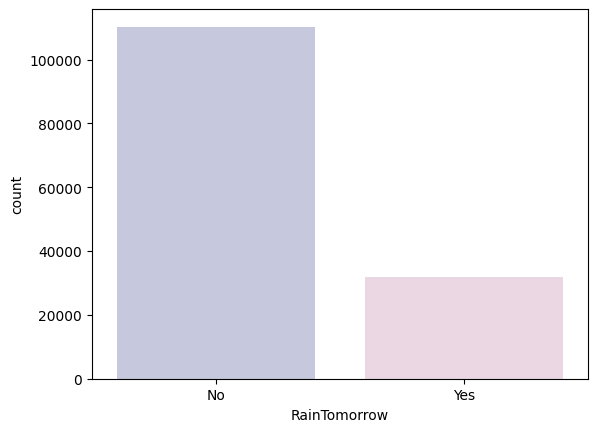

In [60]:
#cek data seimbang atau tidak
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

<Axes: >

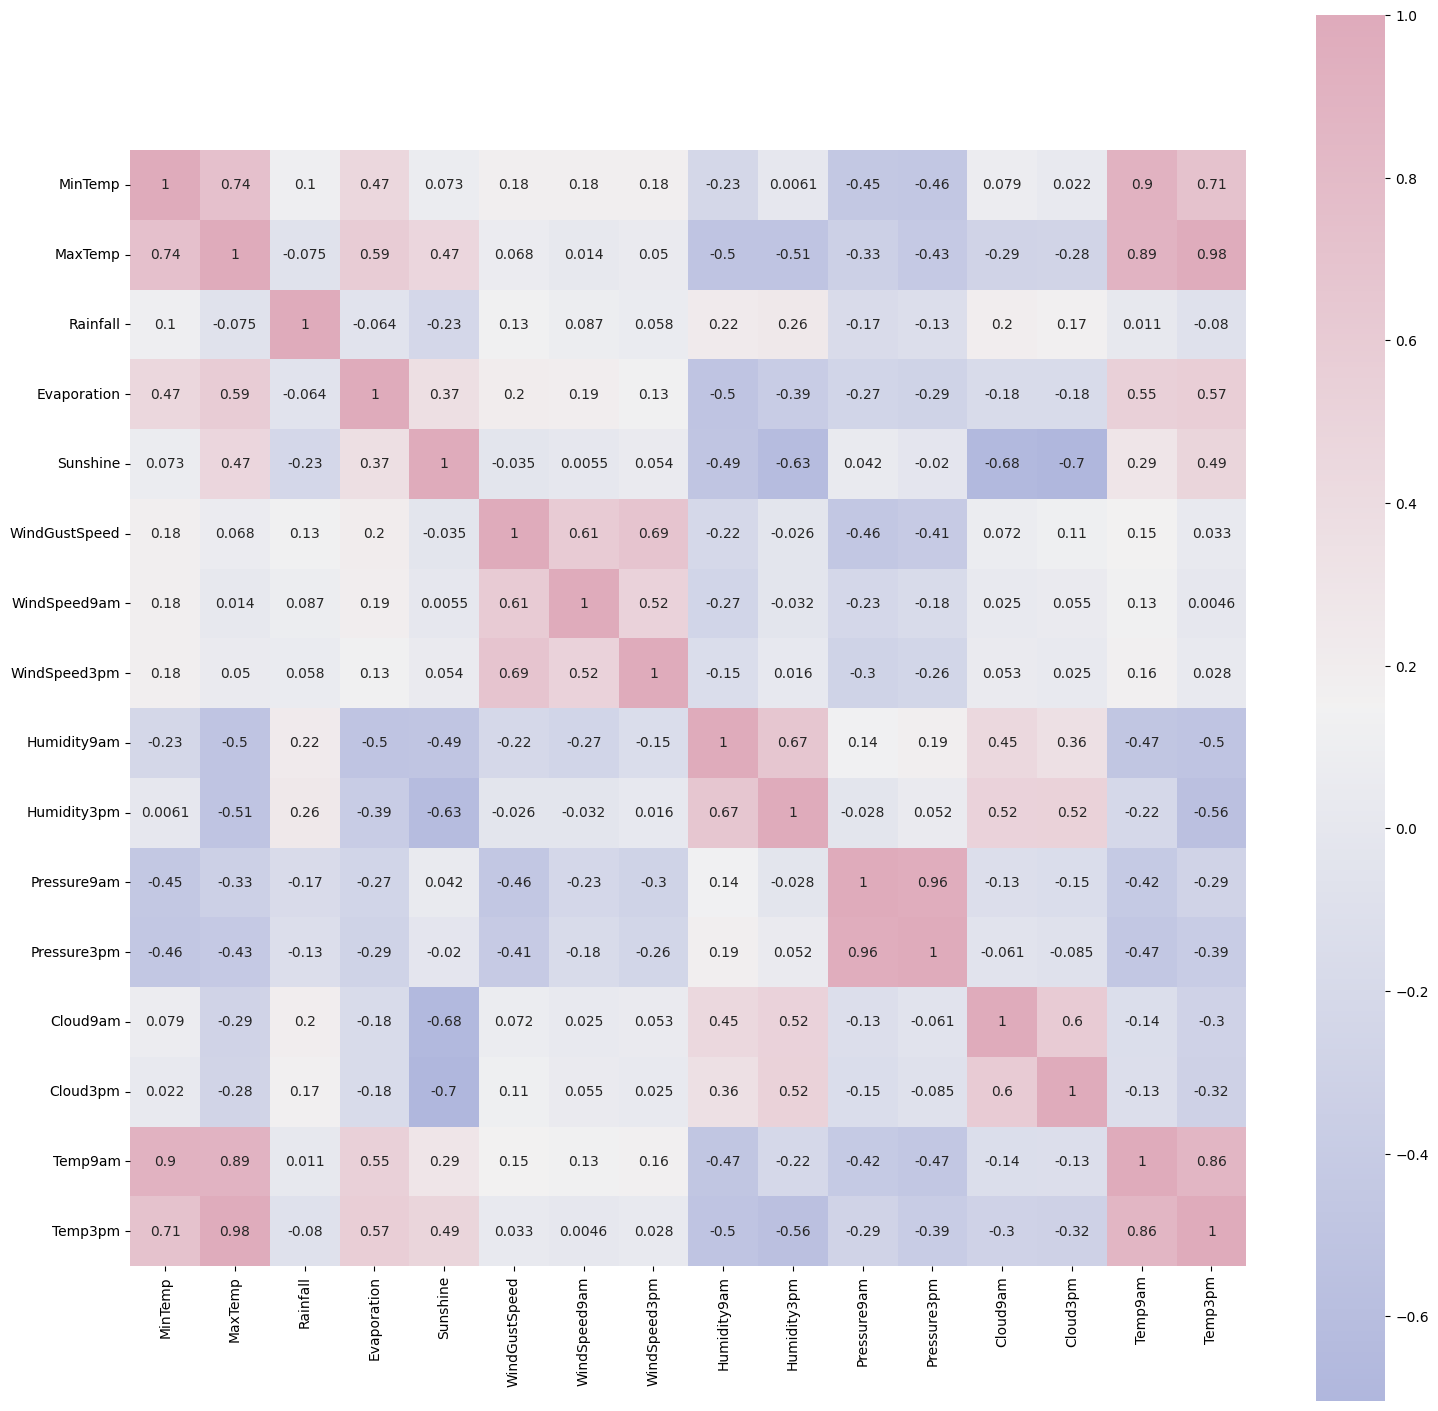

In [61]:
# Korelasi antar atribut numerik
# Ubah kolom 'Tanggal' menjadi objek datetime jika belum
data['Date'] = pd.to_datetime(data['Date'])

# Ekstrak fitur numerik untuk perhitungan korelasi
numeric_data = data.select_dtypes(include=np.number)

corrmat = numeric_data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

**Sekarang saya akan menguraikan tanggal menjadi waktu.**

Tujuan saya adalah untuk membangun sebuah jaringan syaraf tiruan (JST). Saya akan mengkodekan tanggal dengan tepat, yaitu saya lebih memilih bulan dan hari dalam fitur kontinu siklik. Karena, tanggal dan waktu pada dasarnya bersifat siklus. Untuk memberi tahu model ANN bahwa suatu fitur bersifat siklus, saya membaginya menjadi beberapa subbagian berkala. Yaitu, tahun, bulan, dan hari. Sekarang untuk setiap subbagian, saya membuat dua fitur baru, yang berasal dari transformasi sinus dan transformasi kosinus dari fitur subbagian.

In [62]:
#Parsing datetime
#menjelajahi panjang objek tanggal
#lengths = data["Date"].str.len() # Baris ini menyebabkan kesalahan
lengths = data["Date"].dt.strftime('%Y-%m-%d').str.len() # Convert to string first
lengths.value_counts()

,count
Date,
10,145460


In [63]:
##Sepertinya tidak ada kesalahan pada tanggal sehingga mengurai nilai ke datetime

data['Date']= pd.to_datetime(data["Date"])
#Membuat kolom tahun
data['year'] = data.Date.dt.year

# fungsi untuk mengodekan datetime ke dalam parameter siklik.
#Karena saya berencana untuk menggunakan data ini dalam ANN, saya lebih suka bulan dan hari dalam fitur siklik berkelanjutan.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

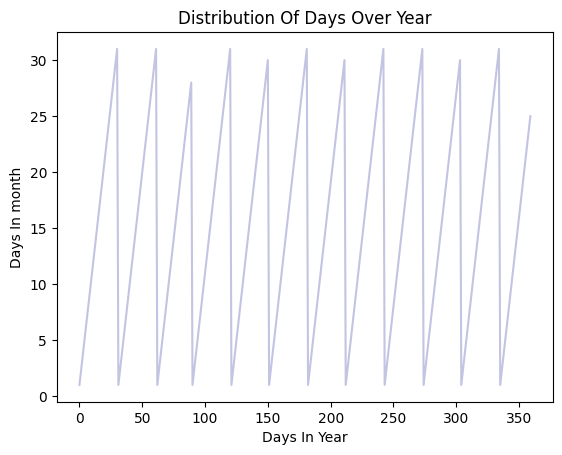

In [64]:
# bagian rentang waktu sekitar satu tahun
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Seperti yang diharapkan, atribut “tahun” dari data berulang. Namun dalam hal ini, sifat siklik yang sebenarnya tidak disajikan secara kontinu. Membagi bulan dan hari menjadi kombinasi sinus dan kosinus memberikan fitur kontinu siklis. Hal ini dapat digunakan sebagai fitur input untuk JST.

Text(0.5, 0, 'Sine Encoded Months')

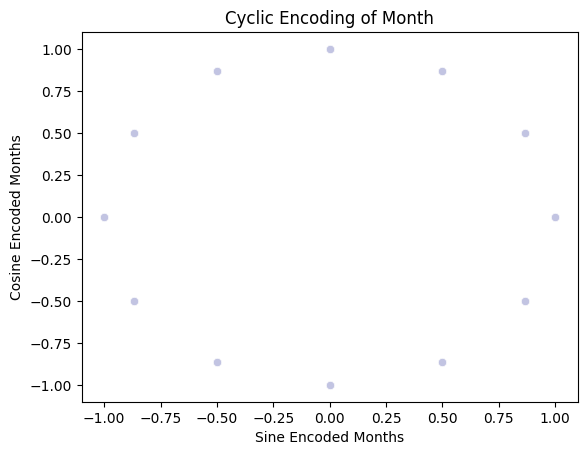

In [65]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

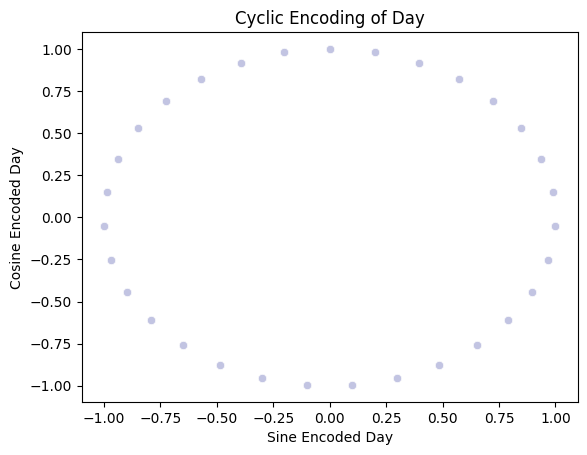

In [66]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Selanjutnya, saya akan membahas nilai yang hilang dalam atribut kategorikal dan numerik secara terpisah

**Variabel kategorikal**

* Mengisi nilai yang hilang dengan modus dari nilai kolom

In [67]:
# Dapatkan daftar variabel kategoris
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [68]:
# Nilai yang hilang dalam variabel kategoris

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [69]:
# Mengisi nilai yang hilang dengan modus kolom dalam nilai

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

<ipython-input-69-d34edc1a3b96>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


**Variabel numerik**

* Mengisi nilai yang hilang dengan median dari nilai kolom

In [70]:
# Dapatkan daftar variabel numerik
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [71]:
# Nilai yang hilang dalam variabel numerik

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [72]:
# Mengisi nilai yang hilang dengan median kolom dalam nilai

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

<ipython-input-72-27e16f0c3c0e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].median(), inplace=True)


Text(0.5, 0, 'Years')

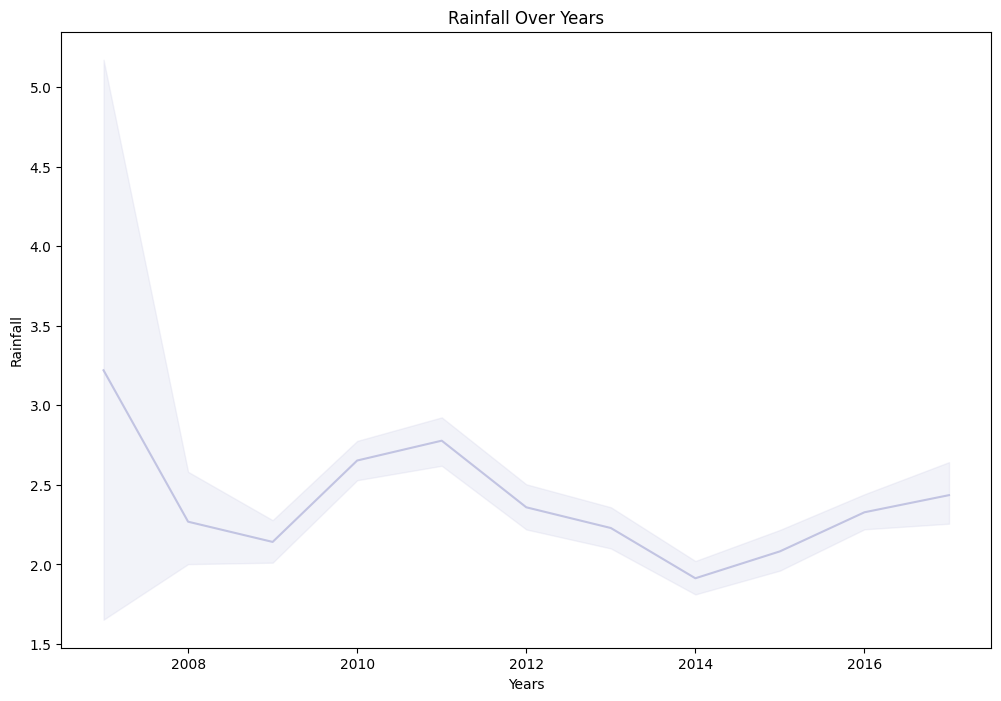

In [73]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="#C2C4E2")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

<ipython-input-74-ac0e1497f1e4>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-74-ac0e1497f1e4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-74-ac0e1497f1e4>:4: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)


Text(0.5, 0, 'Year')

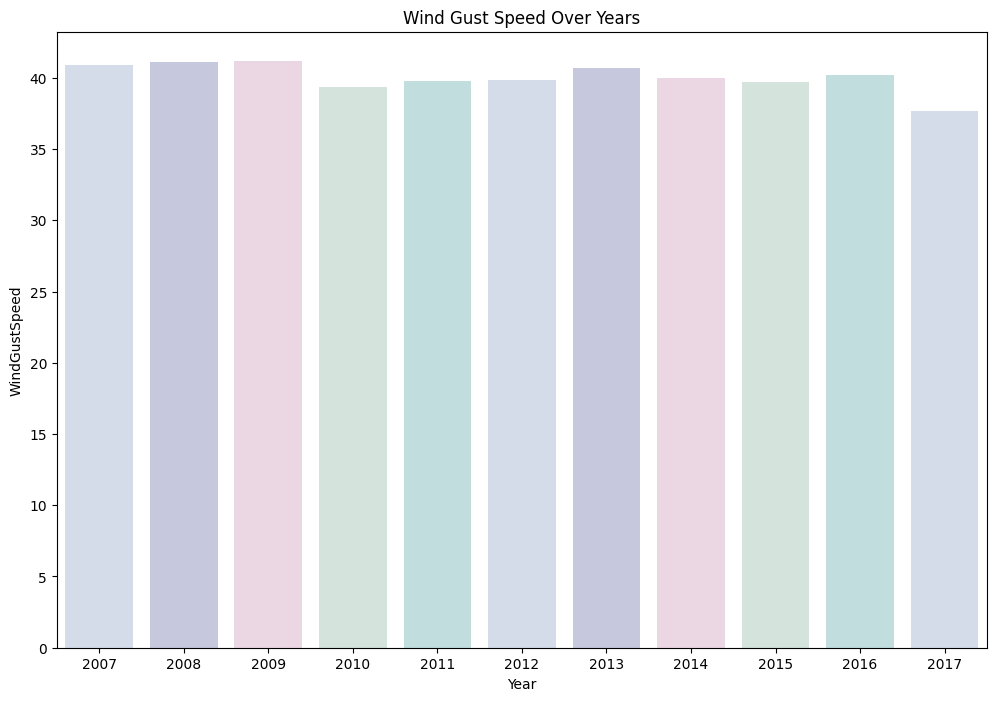

In [74]:
#Mengevaluasi kecepatan hembusan angin selama bertahun-tahun
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

## **Data Preprocessing**

**Langkah-langkah yang terlibat dalam Pemrosesan Data:**

* Memberi label pada kolom pengkodean dengan data kategorikal
* Melakukan penskalaan fitur
* Mendeteksi pencilan
* Menghilangkan pencilan berdasarkan analisis data

**Label yang mengkodekan variabel katagori**

In [75]:
# Terapkan encoder label ke setiap kolom dengan data kategorikal
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [76]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


<ipython-input-77-6d42aad80754>:5: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


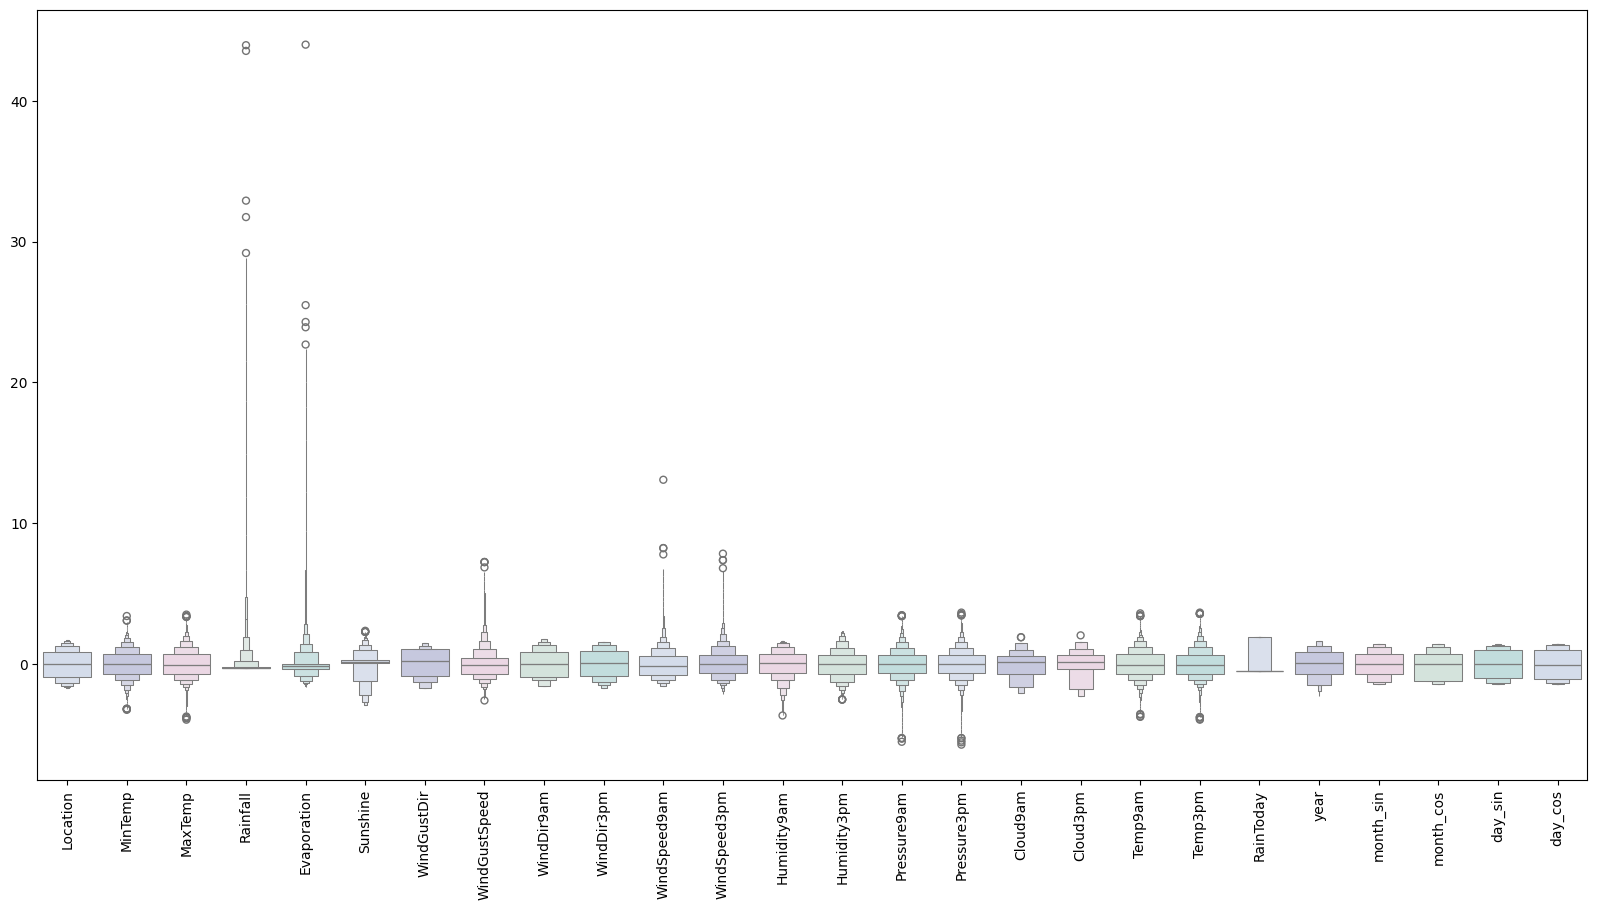

In [77]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [78]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

<ipython-input-79-0b9d7aa52ee8>:4: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


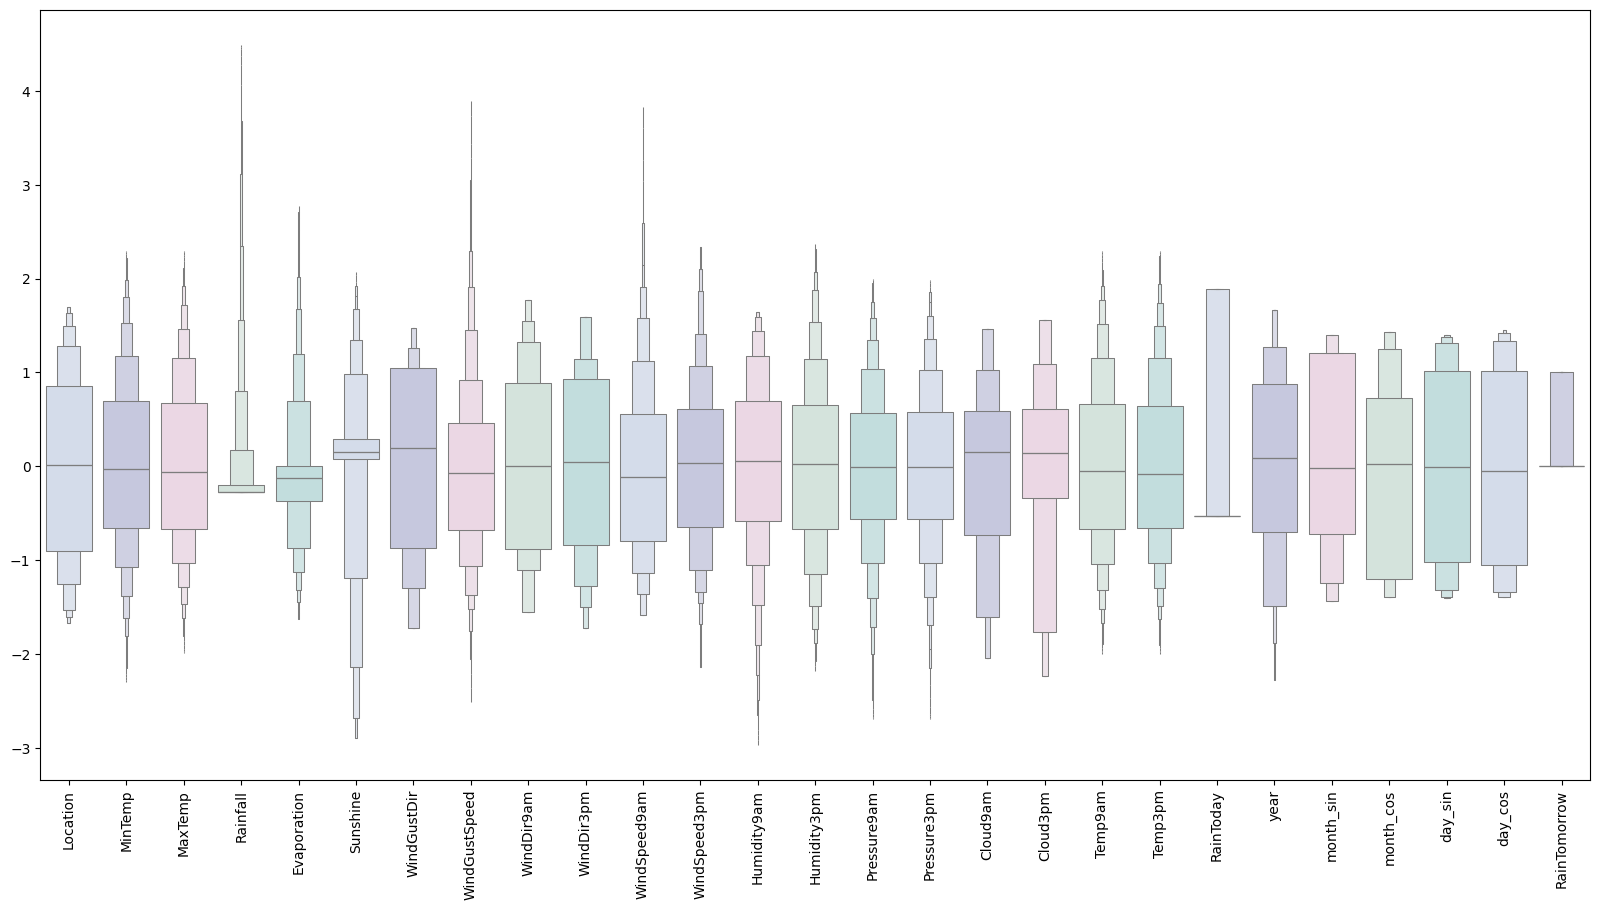

In [79]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [80]:
# Import SMOTE dari imblearn
from imblearn.over_sampling import SMOTE

# 1. Periksa distribusi kelas RainTomorrow
print("Distribusi kelas sebelum SMOTE:")
print(data['RainTomorrow'].value_counts())

# 2. Pra-pemrosesan data
# Misalnya, asumsikan Anda sudah menangani nilai hilang dan encoding kolom kategorikal
# Pisahkan fitur (X) dan target (y)
X = data.drop(['RainTomorrow', 'Date', 'Location'], axis=1)  # Sesuaikan kolom yang di-drop
y = data['RainTomorrow']

# Encode kolom kategorikal
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column].astype(str))

# Encode target (RainTomorrow: Yes/No menjadi 1/0)
y = le.fit_transform(y)

# Isi nilai hilang (jika ada)
X = X.fillna(X.mean())  # Mengisi nilai hilang dengan rata-rata kolom

# Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Terapkan SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# 4. Verifikasi distribusi kelas setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_balanced).value_counts())

# 5. Konversi kembali ke DataFrame (opsional, untuk kemudahan penggunaan)
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)
y_balanced_df = pd.Series(y_balanced, name='RainTomorrow')

Distribusi kelas sebelum SMOTE:
RainTomorrow
0    113583
1     31877
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
0    113583
1    113583
Name: count, dtype: int64


## **Modelling**
**Dalam proyek ini, kami membangun jaringan syaraf tiruan.**

**Langkah-langkah berikut ini terlibat dalam pembangunan model**

* Menetapkan status atribut dan tag X dan y
* Memisahkan set pengujian dan pelatihan
* Menginisialisasi jaringan syaraf tiruan
* Mendefinisikan dengan menambahkan lapisan
* Menyusun jaringan syaraf tiruan
* Melatih jaringan saraf tiruan

In [81]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

In [82]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2551/2551 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7823 - loss: 0.5634 - val_accuracy: 0.7860 - val_loss: 0.3921
Epoch 2/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7875 - loss: 0.4162 - val_accuracy: 0.8391 - val_loss: 0.3846
Epoch 3/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8111 - loss: 0.4062 - val_accuracy: 0.8409 - val_loss: 0.3776
Epoch 4/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8149 - loss: 0.3989 - val_accuracy: 0.8415 - val_loss: 0.3725
Epoch 5/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8113 - loss: 0.3970 - val_accuracy: 0.8419 - val_loss: 0.3704
Epoch 6/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8156 - loss: 0.3965 - val_accuracy: 0.8426 - val_loss: 0.3690
Epoch 7/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8124 - loss: 0.3959 - val_accuracy: 0.8434 - val_loss: 0.3674
Epoch 8/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8159 - loss: 0.3935 

Plotting training and validation loss over epochs

Kode ini membangun Feed-Forward Artificial Neural Network (ANN) menggunakan Keras Sequential. Model terdiri dari beberapa lapisan Dense fully connected dengan aktivasi ReLU, dropout untuk mencegah overfitting, dan sigmoid di output untuk klasifikasi biner. Optimizer Adam digunakan dengan learning rate kecil. Fungsi loss-nya adalah binary_crossentropy. Proses pelatihan memakai early stopping untuk menghentikan training jika tidak ada peningkatan validasi selama 20 epoch. Model dilatih maksimal 150 epoch dengan validasi 20% dan batch size 32.

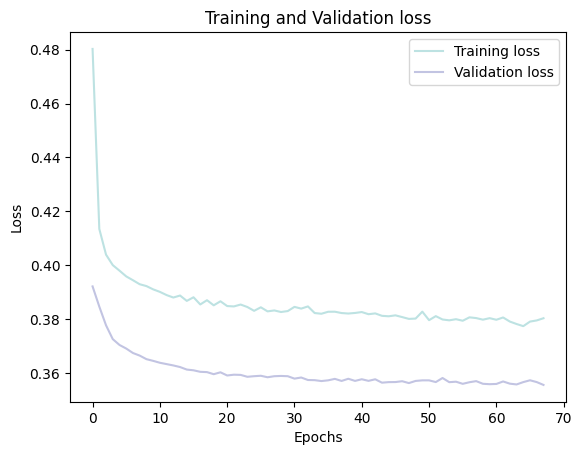

In [83]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Ini untuk memvisualisasikan performa pelatihan model ANN dalam bentuk grafik loss. Pertama, objek history, yang menyimpan riwayat pelatihan model, dikonversi menjadi DataFrame dengan pd.DataFrame(history.history) agar lebih mudah dianalisis. Kemudian, grafik dibuat menggunakan matplotlib untuk menampilkan training loss dan validation loss pada setiap epoch. Warna biru muda digunakan untuk training loss dan ungu muda untuk validation loss. Grafik diberi judul, label sumbu X (Epochs) dan Y (Loss), serta legenda otomatis di posisi terbaik. Visualisasi ini berguna untuk mengevaluasi performa model, misalnya untuk mendeteksi overfitting jika validation loss meningkat sementara training loss terus menurun.

Plotting training and validation accuracy over epochs

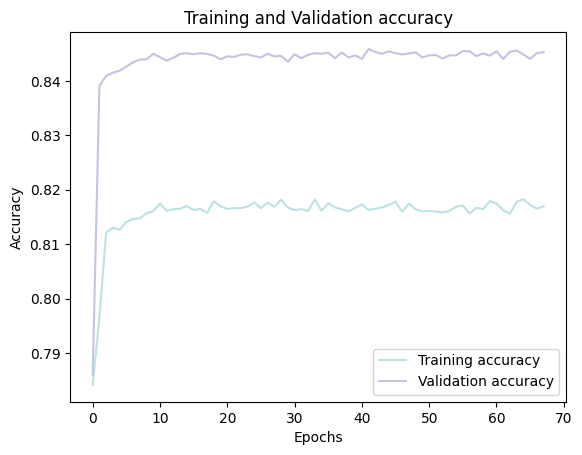

In [84]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ini memvisualisasikan akurasi pelatihan model ANN selama proses training. Pertama, hasil pelatihan yang tersimpan dalam objek history dikonversi menjadi DataFrame menggunakan pd.DataFrame(history.history). Kemudian, grafik dibuat menggunakan matplotlib untuk menampilkan perubahan nilai training accuracy dan validation accuracy di setiap epoch. Warna biru muda digunakan untuk training accuracy, dan ungu muda untuk validation accuracy. Grafik diberi judul serta label pada sumbu X (Epochs) dan Y (Accuracy), dan legenda ditampilkan untuk membedakan kedua kurva. Visualisasi ini membantu mengevaluasi kinerja model dan melihat apakah model belajar secara konsisten terhadap data pelatihan dan validasi.

## **Kesimpulan**

**Menyimpulkan model dengan:**

* Menguji pada set pengujian
* Mengevaluasi matriks kebingungan
* Mengevaluasi laporan klasifikasi

In [85]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

798/798 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

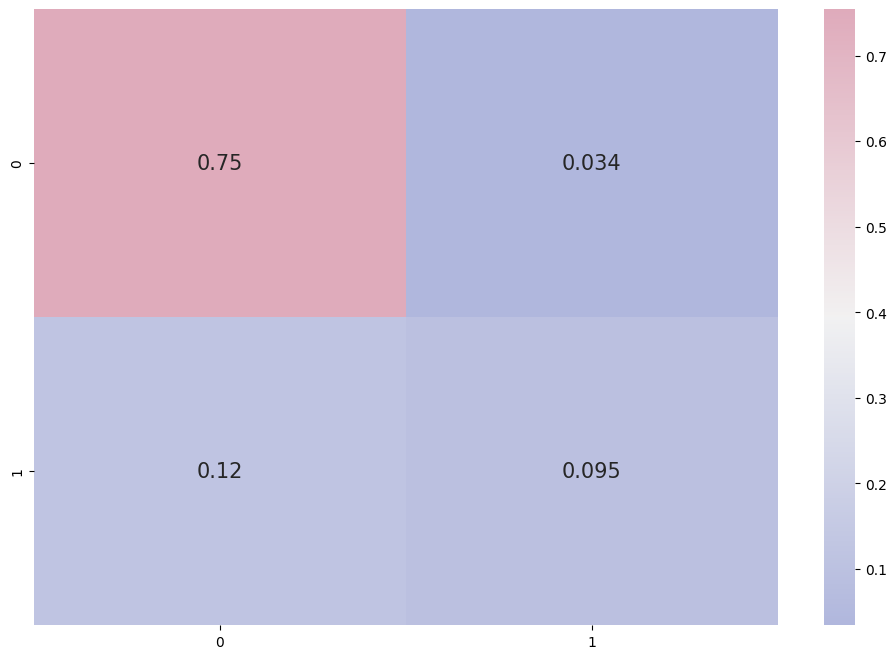

In [86]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [87]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((102028, 26), (25508, 26), (102028,), (25508,))

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     20110
           1       0.73      0.45      0.56      5398

    accuracy                           0.85     25508
   macro avg       0.80      0.70      0.73     25508
weighted avg       0.84      0.85      0.83     25508



# PREDIKSI

Prediksi Kemungkinan Hujan untuk 10 Minggu ke Depan:
      Minggu  Probabilitas Hujan (Rata-rata)              Interpretasi
0   Minggu 1                        0.469829  Kemungkinan Hujan Rendah
1   Minggu 2                        0.469829  Kemungkinan Hujan Rendah
2   Minggu 3                        0.469829  Kemungkinan Hujan Rendah
3   Minggu 4                        0.469829  Kemungkinan Hujan Rendah
4   Minggu 5                        0.469829  Kemungkinan Hujan Rendah
5   Minggu 6                        0.469829  Kemungkinan Hujan Rendah
6   Minggu 7                        0.469829  Kemungkinan Hujan Rendah
7   Minggu 8                        0.469829  Kemungkinan Hujan Rendah
8   Minggu 9                        0.469829  Kemungkinan Hujan Rendah
9  Minggu 10                        0.469829  Kemungkinan Hujan Rendah


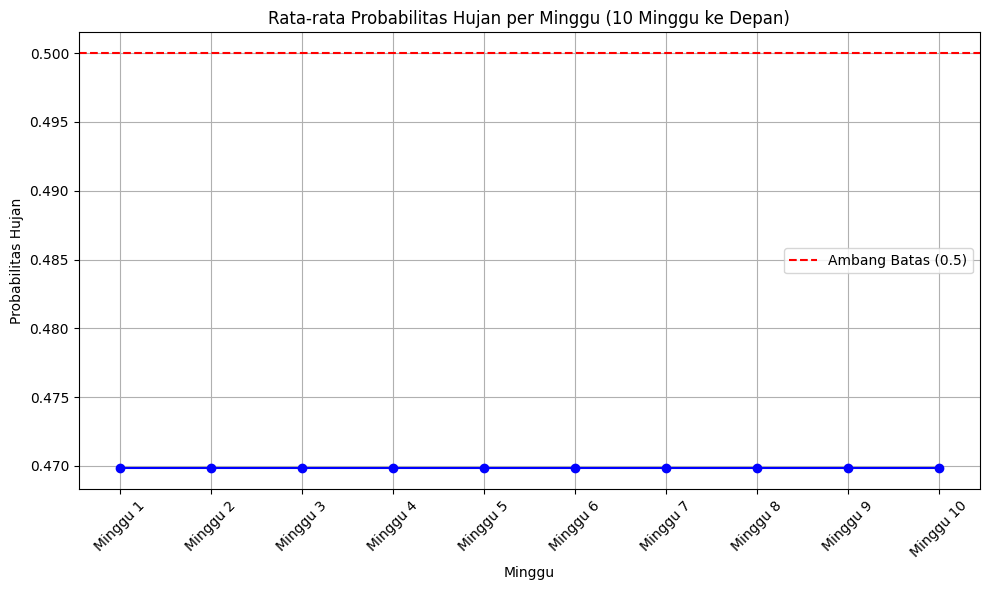

In [90]:
import numpy as np
import pandas as pd

# Asumsi: model sudah dilatih dan tersedia dari kode sebelumnya
# model = model yang sudah dilatih (Sequential ANN dari kode)
# X_train = data pelatihan yang digunakan untuk mendapatkan fitur rata-rata

# Jumlah hari untuk 10 minggu (10 minggu x 7 hari = 70 hari)
n_days = 70

# Menggunakan fitur rata-rata dari X_train sebagai input untuk prediksi
# (karena tidak ada data fitur masa depan)
mean_features = np.mean(X_train, axis=0).values.reshape(1, -1)

# Array untuk menyimpan probabilitas hujan untuk setiap hari
daily_probabilities = []

# Prediksi untuk setiap hari
for day in range(n_days):
    # Prediksi probabilitas hujan
    pred_prob = model.predict(mean_features, verbose=0)
    daily_probabilities.append(pred_prob[0][0])

# Konversi ke array numpy
daily_probabilities = np.array(daily_probabilities)

# Mengelompokkan probabilitas per minggu (rata-rata probabilitas harian per minggu)
weekly_probabilities = []
for week in range(10):
    start_idx = week * 7
    end_idx = start_idx + 7
    weekly_avg_prob = np.mean(daily_probabilities[start_idx:end_idx])
    weekly_probabilities.append(weekly_avg_prob)

# Membuat DataFrame untuk hasil
weeks = [f"Minggu {i+1}" for i in range(10)]
results = pd.DataFrame({
    "Minggu": weeks,
    "Probabilitas Hujan (Rata-rata)": weekly_probabilities,
    "Interpretasi": ["Kemungkinan Hujan Tinggi" if prob > 0.5 else "Kemungkinan Hujan Rendah" for prob in weekly_probabilities]
})

# Menampilkan hasil
print("Prediksi Kemungkinan Hujan untuk 10 Minggu ke Depan:")
print(results)

# Visualisasi hasil
plt.figure(figsize=(10, 6))
plt.plot(weeks, weekly_probabilities, marker='o', color='b')
plt.axhline(y=0.5, color='r', linestyle='--', label='Ambang Batas (0.5)')
plt.title("Rata-rata Probabilitas Hujan per Minggu (10 Minggu ke Depan)")
plt.xlabel("Minggu")
plt.ylabel("Probabilitas Hujan")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Prediksi Kemungkinan Hujan untuk 10 Hari ke Depan (Input Hari Hujan):
      Hari  Probabilitas Hujan Prediksi
0   Hari 1            0.645656    Hujan
1   Hari 2            0.645656    Hujan
2   Hari 3            0.645656    Hujan
3   Hari 4            0.645656    Hujan
4   Hari 5            0.645656    Hujan
5   Hari 6            0.645656    Hujan
6   Hari 7            0.645656    Hujan
7   Hari 8            0.645656    Hujan
8   Hari 9            0.645656    Hujan
9  Hari 10            0.645656    Hujan


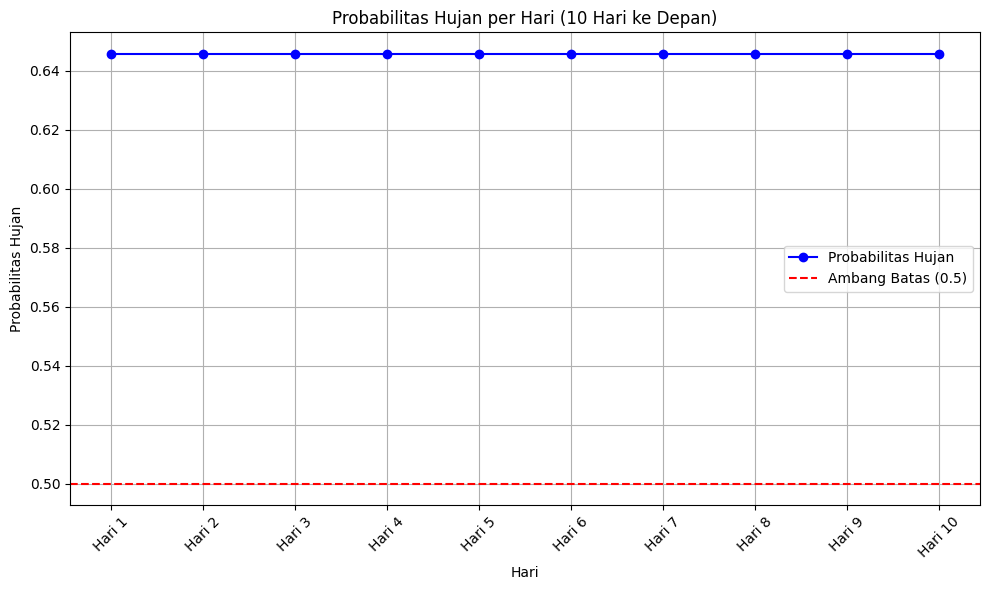

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asumsi: model dan X_train, y_train sudah tersedia
n_days = 10

# Opsi 1: Gunakan input rata-rata dari hari hujan untuk meningkatkan kemungkinan prediksi "Hujan"
rainy_days = X_train[y_train == 1]
new_data_point = np.mean(rainy_days, axis=0).values.reshape(1, -1)

# Array untuk menyimpan probabilitas dan prediksi
daily_probabilities = []
daily_predictions = []

# Prediksi untuk setiap hari
for day in range(n_days):
    pred_prob = model.predict(new_data_point, verbose=0)
    prob = pred_prob[0][0]

    predicted_class = (prob > 0.5).astype("int32")
    daily_probabilities.append(prob)
    daily_predictions.append("Hujan" if predicted_class == 1 else "Tidak Hujan")

# Buat DataFrame untuk hasil
days = [f"Hari {i+1}" for i in range(n_days)]
results = pd.DataFrame({
    "Hari": days,
    "Probabilitas Hujan": daily_probabilities,
    "Prediksi": daily_predictions
})

# Tampilkan hasil
print("Prediksi Kemungkinan Hujan untuk 10 Hari ke Depan (Input Hari Hujan):")
print(results)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.plot(days, daily_probabilities, marker='o', color='b', label='Probabilitas Hujan')
plt.axhline(y=0.5, color='r', linestyle='--', label='Ambang Batas (0.5)')  # Sesuaikan ambang batas
plt.title("Probabilitas Hujan per Hari (10 Hari ke Depan)")
plt.xlabel("Hari")
plt.ylabel("Probabilitas Hujan")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()